In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import interpolation
from statsmodels.stats.anova import AnovaRM
import time
import sys
import math
import pylab as py
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import scipy.stats as sci 
import seaborn as sns
import statannot
import json
from scipy import signal

# sns.set_style(style='whitegrid')

In [2]:
import os
os.getcwd() 

'C:\\Users\\PC\\Documents\\Projects\\Github\\SubEscape\\SubEscape_Data_Analysis'

In [3]:
import Files2DataFrame as f2d

In [4]:
%load_ext autoreload
%autoreload 2

## Functions

In [5]:
def GetAng(a,b,c):
    ang = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    return 360 - (ang + 360 if ang < 0 else ang)

In [6]:
def ResizeArray(data, newSize):
    x = data
    i = newSize

    lenX = len(x)

    if lenX == 0:
        lenX = 1
        z = i / lenX
    else:
        z = i / lenX
        x_int = interpolation.zoom(x,z)

    return x_int

In [7]:
def ReadFiles(path, files):
    # Define data frame variable
    df = None 
    startTime = time.time()
  
    print('Number of files: ', len(files))
    
    # Load each file into the data frame 
    for i in range(len(files)): 
    
        if ".json" in files[i] and "Phase" in files[i] and "QNumber" not in files[i]:    
        # if "txt.json" in files[i] and "Phase" in files[i]:
              # print(files[i])

            # elapsedTime = time.time() - startTime
            # print('Time passed: ', np.round(elapsedTime), '\t sec \r')

            # Extract file name info and add to the dataframe 
            fileWords = files[i].split("_")

            # Extract phase 
            idx = fileWords.index("Phase")
            phase = fileWords[idx + 1]

            # Extract user ID 
            idx = fileWords.index("trial")
            userID = fileWords[idx - 1]

            # Add trial number to data frame 
            try:
#                 print('Path and File: ', [path + '/' + files[i]])
                tmpDF = pd.read_json(path + '/' + files[i])
                tmpDF.insert(0, "Phase", phase, True)
                tmpDF.insert(0, "UserID", userID, True)

                if df is None:
                    df = tmpDF
                else:
                    df = pd.concat((df, tmpDF))
            except Exception as e:
                print('My_Err: ', e)
    return df

In [8]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [9]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

#     print list
#     for x in unique_list:
#         print (x)

    return unique_list

In [10]:
def Extract_DialAngle(dataFrame):
    
    tmpDF = dataFrame #pd.read_json(path + f, orient='index')

    # Extract pose data from each of the metrics 
    dial = []
    target = []
    score = []

    # tmpDF.loc['dialData'].values[0][i]
    for i in tmpDF.loc['dialData'].values[0]: 
        metricParts = str.split(i,';')
        dial.append(float(metricParts[0]))
        target.append(float(metricParts[1]))
        score.append(float(metricParts[2]))

    data = {'Dial_Raw' : dial,
           'Target' : target,
           'Score' : score,}

    tmpDF2 = pd.DataFrame(data)
#     tmpDF2.insert(0,'PtxID',ptxIDs)
#     tmpDF2.insert(1,'trial',trial)
#     tmpDF2.insert(2,'group',group)
#     tmpDF2.insert(3,'hand',hand)
#     tmpDF2.insert(4,'age',age)
#     tmpDF2.insert(5,'sex',sex)

    return tmpDF2

In [11]:
def Extract_FingerData(dataFrame, fingerType):
    
    tmpDF = dataFrame
    frameColumns = []
    
    if 'virtual' in fingerType:
        fingerType = 'vfingData' 
        frameColumns = ['VFrame','VJoint','VxPos','VyPos','VzPos','Vrot']
    else:
        fingerType = 'fingData'
        frameColumns = ['Frame','Joint','xPos','yPos','zPos','rot']
    
    # Extract finger data ----------------------------------------
    frame = []
    joint = []
    xPos = []
    yPos = []
    zPos = []
    rot = [] 
    for i in np.arange(len(tmpDF.loc[fingerType].values[0])):
        metricParts = str.split(tmpDF.loc[fingerType].values[0][i],';')
        frame.append(int(metricParts[0]))
        joint.append(metricParts[1])
        xPos.append(float(metricParts[2]))
        yPos.append(float(metricParts[3]))
        zPos.append(float(metricParts[4]))
        rot.append(float(metricParts[5]))

    data2 = {frameColumns[0] : frame,
           frameColumns[1] : joint,
           frameColumns[2] : xPos,
           frameColumns[3] : yPos,
           frameColumns[4] : zPos,
           frameColumns[5] : rot,}

    tmpDF3 = pd.DataFrame(data2)
    
    return tmpDF3

### Reconstruct dial angle 

In [12]:
def DialAngleRecon(df_all, fingerType):
    
    jointsOfInterest = ['b_l_thumb1', 'b_l_thumb2', 'b_l_thumb3',
                    'b_l_index1', 'b_l_index2', 'b_l_index3',
                    'b_l_middle1', 'b_l_middle2', 'b_l_middle3',
                    'b_l_ring1', 'b_l_ring2', 'b_l_ring3',
                    'b_l_pinky1', 'b_l_pinky2', 'b_l_pinky3',
                    'b_l_wrist']

    childJoints = jointsOfInterest[:-1]
    graphData = False

    invX = 0
    invY = 0
    invZ = 0

    # Reconstruct Original Dial Angles from relative finger joints and wrist positions 
    for j in childJoints:
        
        if 'virtual' in fingerType:
            mask = (df_all['VJoint'] == j)
            maskWrist = (df_all['VJoint'] == jointsOfInterest[-1]) 

            invX +=  np.sqrt((df_all[mask]['VxPos'].values - df_all[maskWrist]['VxPos'].values) ** 2)
            invY +=  np.sqrt((df_all[mask]['VyPos'].values - df_all[maskWrist]['VyPos'].values) ** 2)
            invZ +=  np.sqrt((df_all[mask]['VzPos'].values - df_all[maskWrist]['VzPos'].values) ** 2)
        else:
            mask = (df_all['Joint'] == j)
            maskWrist = (df_all['Joint'] == jointsOfInterest[-1]) 

            invX +=  np.sqrt((df_all[mask]['xPos'].values - df_all[maskWrist]['xPos'].values) ** 2)
            invY +=  np.sqrt((df_all[mask]['yPos'].values - df_all[maskWrist]['yPos'].values) ** 2)
            invZ +=  np.sqrt((df_all[mask]['zPos'].values - df_all[maskWrist]['zPos'].values) ** 2)

            
    cA_Temp = np.nansum([invX * 0.067, (invY * 0.067)], axis=0)
    currentAngle = np.nansum([cA_Temp, (invZ * 0.067)], axis=0)

    leftMin = np.nanmin(currentAngle) # leftMin = 0.045
    leftMax = np.nanmax(currentAngle) # leftMax = 0.115
    dialAngleRecon = []

    for cA in currentAngle:
        dialAngleRecon.append(translate(cA, leftMin, leftMax, 0.1, 179.9))

    dialAngleRecon = [i + 7.5 for i in dialAngleRecon] # Add offset value of 7.5 degrees to the reconstructed dial angle to match the original Unity environment and script (see MoveDial.cs)

    return dialAngleRecon

# Original Unity app code for reference ----------------------------------------------------
# Vector3 currentHandData = new Vector3();--------------------------------------------------
# for (int i = 0; i < virtualDigits.Length - 1; i++)----------------------------------------
# {-----------------------------------------------------------------------------------------
#-----currentHandData += virtualDigits[16].InverseTransformPoint(virtualDigits[i].position);
# }{----------------------------------------------------------------------------------------
# float currentAngle = (currentHandData.x * 0.067f) +---------------------------------------
#----------------(currentHandData.y * 0.067f) +---------------------------------------------
#----------------(currentHandData.z * 0.067f);----------------------------------------------
# currentAngle = Mathf.Abs(currentAngle);---------------------------------------------------

### Curve fitting functions

## Main  
This cell below extracts all the relevant data to create the main dataframe  

In [13]:
# path = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
# path = "C:/Users/ObiPC/Documents/Projects/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
# path = "D:/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
# path = "G:/Diar SSD/Projects/GitHub/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
path = "C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/"

## Multiprocessing

In [80]:
# import multiprocessing as mp
import Files2DataFrame as f2d

In [81]:
f2d.my_func(9)

387420489

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# pathOuside = "G:/Diar SSD/Projects/GitHub/"
# pathOuside = "K:/Diar SSD/Projects/GitHub/"
# pathOuside = "H:/Project/"
pathOuside = "C:/Users/PC/Documents/Projects/Github/"

In [15]:
df_all = pd.read_pickle(pathOuside + "1648778067.0Sub_Raw_DataFrame_1.pkl")
tmp = pd.read_pickle(pathOuside + "1648778121.0Sub_Raw_DataFrame_2.pkl")
df_all = pd.concat((df_all, tmp))
tmp = pd.read_pickle(pathOuside + "1648778188.0Sub_Raw_DataFrame_3.pkl")
df_all = pd.concat((df_all, tmp))

In [69]:
# x = [6,3,54]
# path1 = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_1/"
# path2 = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_2/"
# path3 = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_3/"

path1 = "C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_1/"
path2 = "C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_2/"
path3 = "C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_3/"

paths = [path1,path2,path3]
paths

['C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_1/',
 'C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_2/',
 'C:/Users/PC/Documents/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/path_3/']

In [57]:
if __name__ == "__main__":
    result = f2d.main4(paths)

In [21]:
result[0].to_pickle(str(np.round(time.time())) + 'Sub_Raw_DataFrame_1.pkl')
result[1].to_pickle(str(np.round(time.time())) + 'Sub_Raw_DataFrame_2.pkl')
result[2].to_pickle(str(np.round(time.time())) + 'Sub_Raw_DataFrame_3.pkl')

### Compute metrics in parallel

In [30]:
df_all = df_all.reset_index()
np.shape(df_all)

(34315806, 23)

In [71]:
# Restart here for metric computations
result = []
result.append(pd.read_pickle(pathOuside + "1648778067.0Sub_Raw_DataFrame_1.pkl"))
result.append(pd.read_pickle(pathOuside + "1648778121.0Sub_Raw_DataFrame_2.pkl"))
result.append(pd.read_pickle(pathOuside + "1648778188.0Sub_Raw_DataFrame_3.pkl"))

In [78]:
print(type(result), '\n')
print(result[0].head(2), '\n')
print('Number of participants in subset: \n', len(pd.unique(result[0]['PtxID'])),'\n')

<class 'list'> 

              PtxID  trial     group hand age sex  Dial_Raw  Dial_Recon  \
0  vn265606624Yv403      0  NoReward    R  36   M   148.427  122.623569   
1  vn265606624Yv403      0  NoReward    R  36   M   148.427  122.623569   

    Target  Score  ...  VxPos VyPos  VzPos  Vrot  Frame  Joint  xPos yPos  \
0  177.840    0.0  ...    NaN   NaN    NaN   NaN    NaN    NaN   NaN  NaN   
1  176.674    0.0  ...    NaN   NaN    NaN   NaN    NaN    NaN   NaN  NaN   

   zPos  rot  
0   NaN  NaN  
1   NaN  NaN  

[2 rows x 22 columns] 

Number of participants in subset: 
 6 



In [83]:
if __name__ == "__main__":
    metrics = f2d.main5(result)

In [61]:
metrics[0].to_pickle(str(np.round(time.time())) + 'Sub_metrics_1.pkl')
metrics[1].to_pickle(str(np.round(time.time())) + 'Sub_metrics_2.pkl')
metrics[2].to_pickle(str(np.round(time.time())) + 'Sub_metrics_3.pkl')

KeyError: 0

In [54]:
# Restart here for loading metrics 
# Load data frames 
metrics_0 = pd.read_pickle('1648795454.0Sub_metrics_1.pkl')
metrics_1 = pd.read_pickle('1648795454.0Sub_metrics_2.pkl')
metrics_2 = pd.read_pickle('1648795454.0Sub_metrics_3.pkl')

In [58]:
metrics = metrics_0
metrics = pd.concat((metrics, metrics_1))
metrics = pd.concat((metrics, metrics_2))

In [ ]:
# metrics = metrics.reset_index()
metrics[0] =  metrics[0].reset_index()
metrics[1] =  metrics[1].reset_index()
metrics[2] =  metrics[2].reset_index()

In [104]:
df_metrics

,level_0,index,PtxID,Group,Trial,Slope,Intercept,MeanSqErr,MeanAbsErr
0,0,0,vn265606624Yv403,NoReward,0,0.751711,3.918706,1634.197200,22.434365
1,1,1,vn265606624Yv403,NoReward,1,0.972785,0.541898,206.841532,11.367966
2,2,2,vn265606624Yv403,NoReward,2,0.929704,-3.571381,1229.409523,22.400304
3,3,3,vn265606624Yv403,NoReward,3,1.074266,0.988593,238.606633,11.604896
4,4,4,vn265606624Yv403,NoReward,4,0.967266,3.480576,271.971898,13.132121
...,...,...,...,...,...,...,...,...,...
313,313,48,iA94696354Ww734,NoReward,48,0.974948,1.718463,466.048779,16.072341
314,314,49,iA94696354Ww734,NoReward,49,1.007143,2.552962,315.038205,13.793792
315,315,50,iA94696354Ww734,NoReward,50,0.931616,-5.006747,306.869138,12.890560
316,316,51,iA94696354Ww734,NoReward,51,1.024067,0.145560,131.736195,8.759212


In [106]:
df_metrics = metrics[0]
df_metrics = pd.concat((df_metrics, metrics[1]))
df_metrics = pd.concat((df_metrics, metrics[2]))

ValueError: cannot insert level_0, already exists

In [117]:
df_metrics = df_metrics.reset_index(drop=True)
print('Number of participants: ', len(pd.unique(df_metrics['PtxID'])))

Number of participants:  39


<AxesSubplot:xlabel='Trial', ylabel='Slope'>

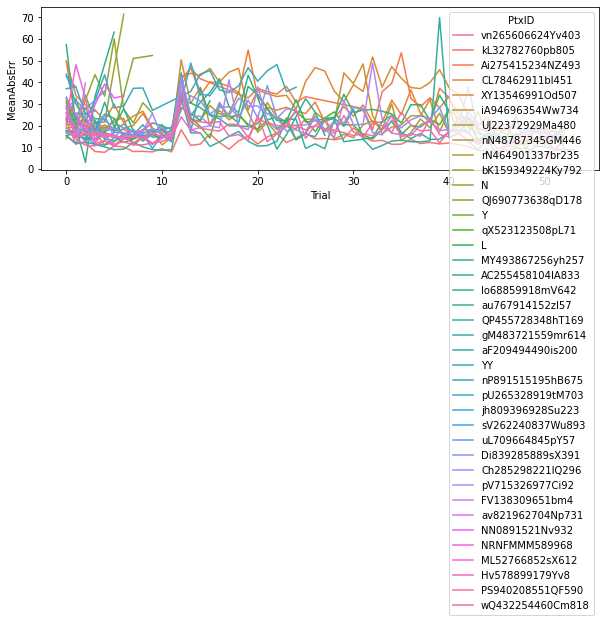

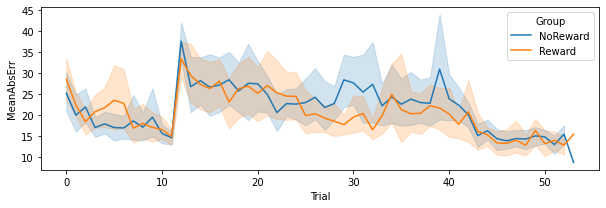

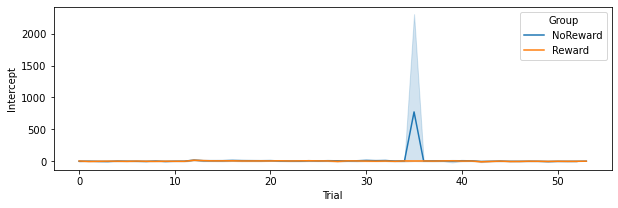

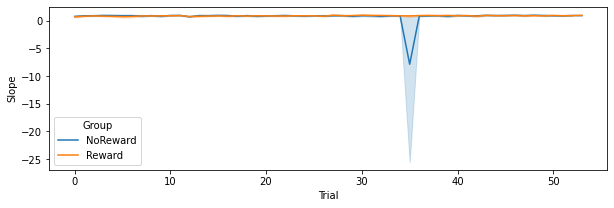

In [116]:
plt.figure(0)
sns.lineplot(x = 'Trial', y = 'MeanAbsErr', hue = 'PtxID', data = df_metrics)
plt.figure(1)
sns.lineplot(x = 'Trial', y = 'MeanAbsErr', hue = 'Group', data = df_metrics)
plt.figure(2)
sns.lineplot(x = 'Trial', y = 'Intercept', hue = 'Group', data = df_metrics)
plt.figure(3)
sns.lineplot(x = 'Trial', y = 'Slope', hue = 'Group', data = df_metrics)

plt.figure(4)
sns.lineplot(x = 'Trial', y = 'Slope', hue = 'PtxID', data = df_metrics)

In [31]:
# # try:
# #     df_all = pd.read_pickle('SubData_All.pkl')
# #     fileLoaded = True
# # except Exception as e:
# #     print('File not found error: ', e)
# #     fileLoaded = False
# fileLoaded = False

# startTime = time.time()

# if not fileLoaded:

#     folders = os.listdir(path)
#     folderNames = unique(folders)
#     df_all = None

#     for f in folderNames[0:1000]:

#         folderWords = str.split(f,'_')
#         if 'json' not in folderWords[-1]:
#             continue
#         else:
#             ptxID = folderWords[1]
#             age = folderWords[2]
#             sex = folderWords[3]
#             hand = folderWords[4]
#             group = folderWords[5]
#             trial = int(folderWords[9])
            
#             # Read raw data file 
#             try:
#                 tmpDF1 = pd.read_json(path + f, orient='index')

# # ******************************************************************************
# # ******************* Extract data section **************************************
                
#                 # Extract real finger data --------------------------------- 
#                 tmpDF2 = Extract_FingerData(tmpDF1, 'real')
                
#                 # Extract virtual finger data ------------------------------
#                 tmpDF3 = Extract_FingerData(tmpDF1, 'virtual')

#                 # Extract dial angle data ----------------------------------                    
#                 tmpDial = Extract_DialAngle(tmpDF1) 
    
#                 # Dial Angle Reconstruction -------------------------------- 
#                 # Use tmpDF2 for real and tmpDF3 for virtual finger 
#                 dialAngReconstructed = DialAngleRecon(tmpDF3, 'virtual') # Virtual finger      
                
#                 # Combine raw and reconstructed dial angle data into one dataframe 
#                 tmpDial.insert(1,'Dial_Recon', dialAngReconstructed)
                
#                 # Combine all data frames ---------------------------------
#                 tmpDF2 = pd.concat((tmpDF3, tmpDF2))
#                 tmpDF2 = pd.concat((tmpDial, tmpDF2))
#                 tmpDF2.insert(0,'PtxID',ptxID)
#                 tmpDF2.insert(1,'trial',trial)
#                 tmpDF2.insert(2,'group',group)
#                 tmpDF2.insert(3,'hand',hand)
#                 tmpDF2.insert(4,'age',age)
#                 tmpDF2.insert(5,'sex',sex)

# # ******************************************************************************
# # ******************************************************************************
                
#                 # Concatenate all resultant data frames into one parent data frame 
#                 if df_all is None:
#                     df_all = tmpDF2
#                 else:
#                     df_all = pd.concat([df_all, tmpDF2])          

#             except Exception as e:
#                 print('Ptx: ', ptxID,' Warning: ', e)
# #     df

# elapsedTime = np.round((time.time() - startTime) / 60.0, 0)
# print('Processing time: ', elapsedTime, ' minutes')

## Restart Here

In [68]:
df_all.to_pickle(str(np.round(time.time())) + 'SubSet_AllMetrics.pkl')

In [110]:
# df_all = pd.read_pickle('SubData_All_Subset.pkl')
# pathOutside = "D:/Projects/Github/"
# pathOutside = "G:/Diar SSD/Projects/GitHub/"
pathOutside = "C:/Users/PC/Documents/Projects/Github/"
df_all = pd.read_pickle(pathOutside + 'March_SubData_All_Subset_AllMetrics.pkl')

In [16]:
# df_all = df_all.reset_index()
df_all

,PtxID,trial,group,hand,age,sex,Dial_Raw,Dial_Recon,Target,Score,...,VxPos,VyPos,VzPos,Vrot,Frame,Joint,xPos,yPos,zPos,rot
0,vn265606624Yv403,0,NoReward,R,36,M,148.427,122.623569,177.840,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vn265606624Yv403,0,NoReward,R,36,M,148.427,122.623569,176.674,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vn265606624Yv403,0,NoReward,R,36,M,148.427,122.623569,175.503,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vn265606624Yv403,0,NoReward,R,36,M,148.427,126.457688,174.325,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,vn265606624Yv403,0,NoReward,R,36,M,148.427,126.457688,173.139,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19000,wQ432254460Cm818,52,NoReward,R,29,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky1,-0.441,14.358,-2.871,323.241
19001,wQ432254460Cm818,52,NoReward,R,29,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky2,-0.433,14.377,-2.848,269.122
19002,wQ432254460Cm818,52,NoReward,R,29,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky3,-0.414,14.379,-2.856,305.244
19003,wQ432254460Cm818,52,NoReward,R,29,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,l_pinky_finger_tip_marker,-0.407,14.372,-2.876,0.000


In [89]:
# Compute average age and filter out ages above 80 
ageString = pd.unique(df_all['age'])

# Clean up ages in case it is empty 
for idx, ag in enumerate(ageString):
    if not ag:
        print('empty')
        ageString[idx] = '200'
        
agesf = []
for idx, ag in enumerate(ageString):
    try: 
        agesf.append(int(ag))
    except:
        agesf.append(np.nan)
        
ages = [ (np.nan * x) if x>80 else x for x in agesf]

# General info about the dataframe
print('Number of participants: ', len(pd.unique(df_all['PtxID'])))
print('Groups: ', len(pd.unique(df_all['group'])))
print('Average Age: ', np.round(np.nanmean(ages)))
print('Groups: ', pd.unique(df_all['group']))
print('Joints: ', pd.unique(df_all[gmask]['Joint'])) 
gmask = (df_all['group'] == 'Reward')
print('Number in' , ' Reward ' , 'Group: ', len(pd.unique(df_all[gmask]['age'])), '\n\n')

df_all.head(2)

empty
Number of participants:  39
Groups:  2
Average Age:  27.0
Groups:  ['NoReward' 'Reward']
Joints:  [nan 'b_l_thumb1' 'b_l_thumb2' 'b_l_thumb3' 'l_thumb_finger_tip_marker'
 'b_l_index1' 'b_l_index2' 'b_l_index3' 'l_index_finger_tip_marker'
 'b_l_middle1' 'b_l_middle2' 'b_l_middle3' 'l_middle_finger_tip_marker'
 'b_l_ring1' 'b_l_ring2' 'b_l_ring3' 'l_ring_finger_tip_marker'
 'b_l_pinky1' 'b_l_pinky2' 'b_l_pinky3' 'l_pinky_finger_tip_marker'
 'b_l_wrist']
Number in  Reward  Group:  16 




,index,PtxID,trial,group,hand,age,sex,Dial_Raw,Dial_Recon,Target,...,VxPos,VyPos,VzPos,Vrot,Frame,Joint,xPos,yPos,zPos,rot
0,0,vn265606624Yv403,0,NoReward,R,36,M,148.427,122.623569,177.840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,vn265606624Yv403,0,NoReward,R,36,M,148.427,122.623569,176.674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualize all trial data for each participant

#### Show target, raw and reconstructed dial angles

In [28]:
# # For each participant show all the trials, with target, raw and reconstructed dial angles
# # fig, axs = plt.subplots(8,7)

# plt.figure(1)

# participants = pd.unique(df_all['PtxID'])
# trials = pd.unique(df_all['trial'])

# for ptx, pt in enumerate(participants):
#     print('Participant: ', ptx, ' / ', len(participants))
#     for tr in trials:

#         mask = (df_all['PtxID'] == pt) &  (df_all['group'] == 'Reward') &  (df_all['trial'] == tr)
#         dial = df_all[mask]['Dial_Raw'].values
#         dialRecon = df_all[mask]['Dial_Recon'].values
#         target = df_all[mask]['Target'].values

#         # Extract group automatically 
#         gmask = (df_all['PtxID'] == pt)
#         grp = df_all[gmask]['group']
#         group = grp.values[0]

#         plt.subplot(8,7,tr+1)
#         plt.plot(target,'k',linewidth = 0.75)
#         plt.plot(dial,'r',linewidth = 0.45)
#         plt.plot(dialRecon,'g',linewidth = 0.25)
#         plt.xticks(fontsize = 3)
#         plt.yticks(fontsize = 3)
#         plt.tight_layout()

#     plt.subplot(8,7,tr+1)
#     plt.plot(0,0,'k')
#     plt.plot(0,0,'r')
#     plt.plot(0,0,'g')
#     plt.legend(['Target','Raw Dial','Recon Dial'])
#     plt.text(-0.05,0, 'ptx_' + str(ptx) + '_' + group ,fontsize=2)
#     plt.savefig(path + "/Figures/" + 'ptx_' + str(ptx) + '_' + str(np.round(time.time())) + "Dial_Reconstruction.png", dpi = 1200)
#     plt.show()
    
#     # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper right')
#     # plt.legend(['Target','Dial','Dial_Reconst.'])
#     # plt.tight_layout()
#     # plt.xlabel('Samples')
#     # plt.ylabel('Angle (degree)')

#### Show regression line through target vs dial data 

In [92]:
def mae(data, ref):
    mae = 0
    c = 0
    for i in data:
        mae += abs(i-ref)
        c += 1
    return mae / c

In [99]:
from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# Fit a line to the raw dial angle data

# define the true objective function
def objective1(x, a, b, c, d): # sine combined with 2nd order polynomial 
	return a * sin(b - x) + c * x**2 + d

def objective2(x, a, b, c, d, e, f): # 5th order polynomial 
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

def objective3(x, a, p, v, f): # Sine function 
    # x = input data 
    # a = amplitude
    # f = frequency aka period (2*pi/f)
    # p = phase shift
    # v = vertical shift 
    return a * sin((f * x) + p) + v

def objective4(x, m, b): # Linear function 
    return (m * x) + b


# define the true objective function
def objective5(x, a, b, c, d, e, f): # sine combined with another sine  
	return (a * sin(b - x) + c) + (d * sin(e - x) + f)


def FitCurve(y, target, func = 1):
    
    # the dataset
    N = len(y)
    x = np.linspace(0, 4*np.pi, N)
    
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x), 1)
    
    # summarize the parameter values
    if func == 1:
        popt, _ = curve_fit(objective1, x, y) # curve fit
        a, b, c, d = popt # objective1  
        y_line = objective1(x_line, a, b, c, d) # calculate the output for the range
    elif func == 2:
        popt, _ = curve_fit(objective2, x, y) # curve fit
        a, b, c, d, e, f = popt # objective2
        y_line = objective2(x_line, a, b, c, d, e, f) # calculate the output for the range
    elif func == 3:
        popt, _ = curve_fit(objective3, x, y) # curve fit
        a, b, c, f = popt # objective3
        y_line = objective3(x_line, a, b, c, f) # calculate the output for the range
    elif func == 4:
        popt, _ = curve_fit(objective4, x, y) # curve fit
        a, b = popt # objective3
        y_line = objective4(x_line, a, b) # calculate the output for the range
    elif func == 5:
        popt, _ = curve_fit(objective5, x, y) # curve fit
        a, b, c, d, e, f = popt # objective3
        y_line = objective5(x_line, a, b, c, d, e, f) # calculate the output for the range
        
    print(popt)

    # create a line plot for the mapping function
    # plot input vs output
    pyplot.scatter(x, target, color='k',linewidth=5)
    pyplot.plot(x, y,'r--',linewidth=3)
    pyplot.plot(x_line, y_line, '-', color='green', linewidth=2)
    pyplot.show()
    
def FitLine(y, target, func = 1, showPlot = False):
    
    # the dataset
    # N = len(y)
    x = target #np.linspace(0, 4*np.pi, N)
    
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x), 1)
    
    # summarize the parameter values
    popt, _ = curve_fit(objective4, x, y) # curve fit
    a, b = popt # objective3
    y_line = objective4(x_line, a, b) # calculate the output for the range

    # create a line plot for the mapping function
    # plot input vs output
    if showPlot:
        pyplot.plot(target, y, 'ko', markersize=0.5)
        pyplot.plot(x_line, y_line, 'r--', linewidth=0.75)
    
    return a, b

In [101]:
math.isnan(np.nan)

True

In [45]:
# Randomly select n from the total pool of participants to speed up data analysis 
participants = pd.unique(df_all['PtxID']) # All participants 

n = 5
index = np.random.choice(len(participants), n, replace=False) 
index
print(index)
participants[index]

[ 3  5 24 13 31]


array(['CL78462911bI451', 'iA94696354Ww734', 'pU265328919tM703',
       'qX523123508pL71', 'FV138309651bm4'], dtype=object)

In [47]:
# # For each participant show all the trials, with target, raw and reconstructed dial angles
# # fig, axs = plt.subplots(8,7)

# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# plt.rcParams["figure.figsize"] = (10,3)

# plt.figure(1)

# trials = pd.unique(df_all['trial'])
# trials = np.sort(trials)

# df_metrics = None 

# startTime = time.time()

# for ptx, pt in enumerate(participants[index]):
#     print('Participant: ', ptx, ' / ', len(participants))
    
#     slopes = []
#     intercepts = []
#     MSE = []
#     MAE = []
#     trialz = []
    
#     for tr in trials:
        
#         # Data collection part 
#         mask = (df_all['PtxID'] == pt) &  (df_all['group'] == 'Reward') &  (df_all['trial'] == tr)
#         dial = df_all[mask]['Dial_Raw'].values
#         dialRecon = df_all[mask]['Dial_Recon'].values
#         target = df_all[mask]['Target'].values
        
#         # Check data and clean up i.e. remove NaNs etc. 
#         if not dialRecon.tolist(): 
#             # print('Warning: --> Empty array')
#             slopes.append(np.nan)
#             intercepts.append(np.nan)
#             MSE.append(np.nan)
#             MAE.append(np.nan)

#         else:
#             # dialRecon = dialRecon[~numpy.isnan(dialRecon)]
#             # target = target[~numpy.isnan(target)]
#             # dialRecon = dialRecon
#             # target = target
            
#             # MSE computation 
#             # mze = mean_squared_error(target, dialRecon)
#             try: 
#                 mze = mean_squared_error(target, dial)
#                 MSE.append(mze)
#             except: 
#                 MSE.append(np.nan)
                
#             try: 
#                 mae = mean_absolute_error(target, dial)
#                 MAE.append(mae)
#             except: 
#                 MAE.append(np.nan)
            
            
#             # For FitLine function replace inf and nan values with the data set mean for that trial 
#             for idx, d in enumerate(dial2_detrend):
#                 if math.isnan(d) or math.isinf(d):
#                     dial2_detrend[idx] = np.nanmean(dial2_detrend)
                    
#             for idx, d in enumerate(target_detrend):
#                 if math.isnan(d) or math.isinf(d):
#                     target_detrend[idx] = np.nanmean(target_detrend)
                
#             # Detrend data by subtracting 90 degrees, i.e. the bias in the data? <--- check why exactly this is ???? 
#             dial2_detrend = dial - 90
#             target_detrend = target - 90
#             try:
#                 slope, intercept = FitLine(dial2_detrend, target_detrend, 4, showPlot)
#                 slopes.append(slope)
#                 intercepts.append(intercept)
#             except:
#                 slopes.append(np.nan)
#                 intercepts.append(np.nan)
            
                        
#             # Plot regression line through data 
#             showPlot = True
#             if showPlot:
#                 plt.subplot(8, 7,tr+1)
                
#                 txt = plt.text(-60, 60, 'MSE:        '  + str(np.round(mze,1)) + '\nSlope:      ' + str(np.round(slope,2)) + '\nIntercept: ' + str(np.round(intercept,1)), fontsize=3, color="Blue")
#                 txt.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='red'))
#                 plt.xticks(fontsize = 3)
#                 plt.yticks(fontsize = 3)

#                 # Show y label on first plot
#                 if tr == 0:
#                     plt.ylabel('Reconstructed Dial', fontsize = 10)
#                     plt.legend(['Data','Fitted'], loc='lower right')
#                 # Show x label on middle plot
#                 if tr == 2:
#                     plt.xlabel('Target', fontsize = 10)
                
#             # plt.tight_layout()
        
#         # Extract group automatically 
#         gmask = (df_all['PtxID'] == pt)
#         grp = df_all[gmask]['group']
#         group = grp.values[0]
#         trialz.append(tr)
    
#     # Data storage part 
#     dat_metrics = {'Trial' : trialz,
#                    'Slope' : slopes,
#                    'Intercept' : intercepts,
#                    'MeanSqErr' : MSE,
#                    'MeanAbsErr' : MAE,}
    
#     tmpDf = pd.DataFrame(dat_metrics)
#     tmpDf.insert(0, 'PtxID', pt)
#     tmpDf.insert(1, 'Group', group)
    
#     if df_metrics is None:
#         df_metrics = tmpDf
#     else:
#         df_metrics = pd.concat((df_metrics, tmpDf))
        
#     plt.savefig(path + "/Figures/" + 'ptx_' + str(ptx) + '_' + str(np.round(time.time())) + "Dial_Reconstruction.png", dpi = 1200)
#     plt.show()

# print('Processing time: ', np.round((time.time() - startTime)/60), ' minutes!')
    
# df_metrics

Participant:  0  /  39


<Figure size 720x216 with 0 Axes>

Participant:  1  /  39


KeyboardInterrupt: 

In [ ]:
df_metrics = df_metrics.reset_index()
sns.lineplot(x = 'Trial', y = 'MeanSqErr', data = df_metrics)

In [18]:
df_metrics.to_pickle(str(np.round(time.time())) + '_DF_Slope_Metrics.pkl')

#### New cuto_pickletting reconstruction method using the original raw dial data as input;

#### Detrend and -90 provide different intercepts???

##### Extract example trial data from one of the participatns

In [23]:
df_metrics.reset_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


<AxesSubplot:xlabel='Trial'>

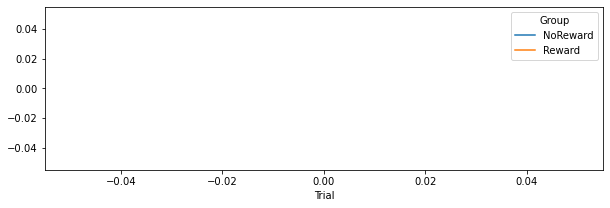

In [24]:
sns.lineplot(x = 'Trial', y = 'MeanAbsErr', hue = 'Group', data=df_metrics)

In [19]:
ptxes = pd.unique(df_all['PtxID'])
mask = (df_all['PtxID'] == ptxes[1]) &  (df_all['group'] == 'Reward') &  (df_all['trial'] == 6)
dial_raw0 = df_all[mask]['Dial_Raw'].values
dial_raw = dial_raw0[~numpy.isnan(dial_raw0)]

targ = df_all[mask]['Target'].values
target = targ[~numpy.isnan(targ)]

dial = df_all[mask]['Dial_Recon'].values
dial2 = dial[~numpy.isnan(dial)]

plt.figure(1)
FitCurve(dial_raw[50:250], target[50:250], 5)


# fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.tight_layout()

plt.subplot(121)
ax[0].plot(target, color = 'k', linewidth=5)
ax[0].plot(dial_raw, 'r--', linewidth=3)
ax[0].plot(dial2, color = 'g')
plt.ylabel('Rotation (Degree)')
plt.xlabel('Samples')
plt.legend(['Target','Raw Dial','Dial Recon'])
plt.tight_layout()
# plt.ylim([0, 180])

# dial2_detrend = signal.detrend(dial2)
# target_detrend = signal.detrend(target)
dial2_detrend = dial2 - 90
target_detrend = target - 90

plt.subplot(122)
# ax[1].plot(target, dial2, 'bo')
showPlot = True
slope, intercept = FitLine(dial2_detrend, target_detrend, 4, showPlot)
plt.text(-50, 75, 'Slope:      ' + str(np.round(slope,2)) + '\nIntercept: ' + str(np.round(intercept,2)))
plt.plot([0,0],[np.max(dial2_detrend), np.max(dial2_detrend)],'k--')
plt.xlabel('Target (Degree)')
plt.ylabel('Dial (Degree)')
plt.tight_layout()

plt.savefig(path + "/Figures/" + "RegressionLine_" + str(np.round(time.time())) + "_.png", dpi=600)
plt.show()

NameError: name 'FitCurve' is not defined

<Figure size 720x216 with 0 Axes>

##### Method 1 (doesn't work so well, i.e. many data points are ignored)

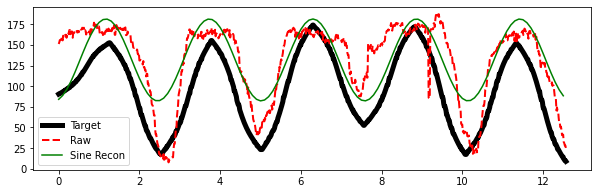

In [20]:
import numpy as np
from scipy.optimize import leastsq
import pylab as plt

N = len(dial2) #1000 # number of data points
t = np.linspace(0, 4*np.pi, N)
f = 1.15247 # Optional!! Advised not to use
data = dial2 #3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = 0.01
guess_freq = 2.35
guess_amp = 200

# Compute a first estimate. This might already be good enough, which I doubt 
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, to minimize the difference
# between the actual dial angle and the "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# Recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

# Recreate the fitted curve using the optimized parameters
fine_t = np.arange(0,max(t),0.1)
data_fit = est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

plt.plot(t, target, 'k-',linewidth=5)
plt.plot(t, data, 'r--',linewidth=2)
# plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='Reconstrcuted',color='g')
plt.legend(['Target','Raw','Sine Recon'])

plt.savefig(path + "/Figures/" + "SineWave_Recon_" + str(np.round(time.time())) + "_.png", dpi=600)

plt.show()

# Old Code

In [ ]:
# plt.subplot(132)
# plt.tight_layout()
# ax[1].plot(dial2, dial_raw, 'k-', linewidth=3)
# ax[1].plot(dial2, dial_raw, 'ro')
# plt.xlim([0, 180])
# plt.ylim([0, 180])
# plt.xlabel('Dial Recon (Degree)')
# plt.ylabel('Raw Dial (Degree)')

In [ ]:
# # Show example plot of raw dial data
# print('Size of t: ', np.shape(t))
# print('Size of dial: ', np.shape(dial))

# # dial = dial
# # dial2 = ResizeArray(dial, 1000)
# # dial2 = [(i * np.nan) for i in dial if i == np.nan]
# dial2 = dial[~numpy.isnan(dial)]
# print('Size of dial after resize: ', np.shape(dial2))

# plt.plot(t)
# plt.plot(dial,'r-o')
# plt.plot(dial2,'g-o')

In [ ]:
# # Test to read more data
# # path = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/"

# folders = os.listdir(path)
# folderNames = unique(folders)
# # df = None 
# # df_all = None

# folderIndex = 160 # Put this into a for loop to go through all the files for the dial 
# f = folderNames[folderIndex]

# folderWords = str.split(f,'_')

# ptxIDs = folderWords[1]
# age = folderWords[2]
# sex = folderWords[3]
# hand = folderWords[4]
# group = folderWords[5]
# trial = folderWords[9]

# tmpDF = pd.read_json(path + f, orient='index')

# # Extract pose data from each of the metrics 
# dial = []
# target = []
# score = []

# # tmpDF.loc['dialData'].values[0][i]
# for i in tmpDF.loc['dialData'].values[0]: 
#     metricParts = str.split(i,';')
#     dial.append(float(metricParts[0]))
#     target.append(float(metricParts[1]))
#     score.append(float(metricParts[2]))

# data = {'Dial' : dial,
#        'Target' : target,
#        'Score' : score,}

# tmpDF2 = pd.DataFrame(data)
# tmpDF2.insert(0,'PtxID',ptxIDs)
# tmpDF2.insert(1,'trial',trial)
# tmpDF2.insert(2,'group',group)
# tmpDF2.insert(3,'hand',hand)
# tmpDF2.insert(4,'age',age)
# tmpDF2.insert(5,'sex',sex)

# tmpDF2

In [ ]:
# def ReadFiles(path, files):
#     # Define data frame variable
#     df = None 
#     startTime = time.time()
  
#     print('Number of files: ', len(files))
    
#     # Load each file into the data frame 
#     for i in range(len(files)): 
    
#         if ".json" in files[i] and "Phase" in files[i] and "QNumber" not in files[i]:    
#         # if "txt.json" in files[i] and "Phase" in files[i]:
#               # print(files[i])

#             # elapsedTime = time.time() - startTime
#             # print('Time passed: ', np.round(elapsedTime), '\t sec \r')

#             # Extract file name info and add to the dataframe 
#             fileWords = files[i].split("_")

#             # Extract phase 
#             idx = fileWords.index("Phase")
#             phase = fileWords[idx + 1]

#             # Extract user ID 
#             idx = fileWords.index("trial")
#             userID = fileWords[idx - 1]

#             # Add trial number to data frame 
#             try:
# #                 print('Path and File: ', [path + '/' + files[i]])
#                 tmpDF = pd.read_json(path + '/' + files[i])
#                 tmpDF.insert(0, "Phase", phase, True)
#                 tmpDF.insert(0, "UserID", userID, True)

#                 if df is None:
#                     df = tmpDF
#                 else:
#                     df = pd.concat((df, tmpDF))
#             except Exception as e:
#                 print('My_Err: ', e)
#     return df

In [ ]:
# frame = { 'headPose': dfs.loc['headPose'].values[0], 
#          'handPose': dfs.loc['headPose'].values[0],
#         'fingData': dfs.loc['fingData'].values[0],
#         'vfingData': dfs.loc['vfingData'].values[0],
#         'dialData': dfs.loc['dialData'].values[0],
#         'trialTime': dfs.loc['trialTime'].values[0],}
  
# df_all = pd.DataFrame(frame)

# df_all

In [ ]:
# # Extract pose data from each of the metrics 
# frame = []
# joint = []
# xPos = []
# yPos = []
# zPos = []
# rot = []
# for i in np.arange(len(dfs.loc['fingData'].values[0])):
#     metricParts = str.split(dfs.loc['fingData'].values[0][i],';')
#     frame.append(metricParts[0])
#     joint.append(metricParts[1])
#     xPos.append(metricParts[2])
#     yPos.append(metricParts[3])
#     zPos.append(metricParts[4])
#     rot.append(metricParts[5])

# data = {'Fame' : frame,
#        'Joint' : joint,
#        'xPos' : xPos,
#        'yPos' : yPos,
#        'zPos' : zPos,
#        'rot' : rot,}

# df_allTest = pd.DataFrame(data)

# df_allTest

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# f =open("1610062712_Qm559862102iI716_44_M_R__NoReward_1018_165_4.txt")

# # convert the file object to a list so one can work on it 
# mylist = [line.rstrip('\n') for line in f] 

# # convert the list to a long string 
# d = str()
# for i in range(len(mylist)):
#     d += mylist[i]
    
# numVars = 8
# # Separate the string into the different variables (;)
# variables = d.split(";")


# # This part is for loading the fingers
# numFingers = 16
# frameRate = 60.24096
# trialDuration = 15
# numAxis = 4
# fingerNames = ['tmb1','tmb2','tmb3',
#                'idx1','idx2','idx3',
#                'mid1','mid2','mid3',
#                'rng1','rng2','rng3',
#                'pnk1','pnk2','pnk3', 'wrist']

# allFingDF = None 
# allData = None 

# fingerPoses = variables[3].split(":") # Separate the different frames (:)

# # Loopify this part later on to go through all the frames and fingers ...
# for fx in range(len(fingerPoses)):
    
#     if len(fingerPoses[fx]) > 470:
        
#         indifings = fingerPoses[fx].split("|")
#         fings = str().join(indifings).split(",")

#         fingX = 0.0
#         fingY = 0.0
#         fingZ = 0.0
#         fingR = 0.0

#         j = 0
#         fc = 0
#         for i in range(len(fings)-1): # Go through each finger (16) and each axis (4) = 64 data points per frame 
            
#             if j == 0:
#                 fingX = float(fings[i+1])
#             elif j == 1:
#                 fingY = float(fings[i+1])
#             elif j == 2:
#                 fingZ = float(fings[i+1])
#             elif j == 3:
#                 fingR = float(fings[i+1])
            
            
#             j = j+1
#             if j > 3:
#                 tmpResampled = [[fingX,fingY,fingZ,fingR]]
#                 tmpRes = pd.DataFrame(tmpResampled,columns=['Fx','Fy','Fz','Fr'])
#                 tmpRes.insert(0, "Participant_ID", variables[0] , True) # Add participant id to dataframe
#                 tmpRes.insert(0, "Trial", variables[2] , True) # Add trial number to dataframe
                
#                 try:
#                     fingerNameArr = fingerNames[fc]
#                     tmpRes.insert(0, "Digit", fingerNameArr, True) # Add digit name to dataframe
#                 except Exception as e: 
#                     print(e)
                    
#                 tmpRes.insert(0, "Frame", fx, True)
                
#                 if allFingDF is None: 
#                     allFingDF = tmpRes
#                 else:
#                     allFingDF = pd.concat((allFingDF, tmpRes))
                    
#                 j = 0
#                 fc = fc+1


# # Plot
# xval = np.arange(len(allFingDF[allFingDF["Digit"] == "tmb1"].Fx))
# trialTime = len(allFingDF[allFingDF["Digit"] == "tmb1"].Fx)/frameRate
# timeVals = np.linspace(0.0,trialTime,len(xval))

# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx1"].Fr,'r')
# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx2"].Fr,'g')
# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx3"].Fr,'b')
# plt.legend(['Dist','Midial','Prox'])

# plt.xlabel("Time / s")
# plt.ylabel("Joint Bend Angle / degrees")
# plt.title("Proximal Index Joint")
# plt.ylim([250.0, 360.0])



# # This part is for loading everything else
# allData = None 

# armPoses = variables[4].split(":") # Separate the different frames (:)
# headPoses = variables[5].split(":") # Separate the different frames (:)
# dialInfo = variables[6].split(":") # Separate the different frames (:)

# armX, armY, armZ, armRx, armRy, armRz = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
# headX, headY, headZ, headRx, headRy, headRz = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
# dialAngle, targetAngle, Score = 0.0, 0.0, 0.0

# # Loopify this part later on to go through all the frames and fingers ...
# for fx in range(len(armPoses)):
    
#     if len(armPoses[fx]) > 40:
        
#         # Other data start -------------------------
#         arms = str().join(armPoses[fx]).split(",")
#         heads = str().join(headPoses[fx]).split(",")
#         dial = str().join(dialInfo[fx]).split(",")
        
#         try:
#             armX = arms[1]
#             armY = arms[2]
#             armZ = arms[3]
#             armRx = arms[4]
#             armRy = arms[5]
#             armRz = arms[6]
            
#             headX = heads[1]
#             headY = heads[2]
#             headZ = heads[3]
#             headRx = heads[4]
#             headRy = heads[5]
#             headRz = heads[6]
            
#             dialAngle = dial[1]
#             targetAngle = dial[2]
#             Score = dial[3]
            
#             tmpAccumulated = [[armX,armY,armZ,armRx,armRy,armRz, 
#                                headX,headY,headZ,headRx,headRy,headRz,
#                                dialAngle,targetAngle,Score]]
#             tmpDats = pd.DataFrame(tmpAccumulated,columns=['armFx','armFy','armFz','armFRx','armFRy','armFRz',
#                                                            'headFx','headFy','headFz','headFRx','headFRy','headFRz',
#                                                            'DialAngle','TargetAngle','Score'])
            
#             tmpDats.insert(0, "Participant_ID", variables[0] , True) # Add participant id to dataframe
#             tmpDats.insert(0, "Trial", variables[2] , True) # Add trial number to dataframe
#             tmpDats.insert(0, "Frame", fx, True)

#             if allFingDF is None: 
#                 allData = tmpDats
#             else:
#                 allData = pd.concat((allData, tmpDats))
        
#         except Exception as e:
#             print("Something went wrong: ", e)
#         # Other data end -------------------------

# # Plot
# xval = np.arange(len(allData.headFx))
# trialTime = len(allData.headFx)/frameRate
# timeVals = np.linspace(0.0,trialTime,len(xval))

# plt.plot(timeVals,allData.DialAngle,'r')
# plt.plot(timeVals,allData.TargetAngle,'g')
# plt.plot(timeVals,allData.Score,'b')
# plt.legend(['Dial','Target','Score'])
# # plt.legend(['Dial','Target'])

# plt.xlabel("Time / s")
# plt.ylabel("Dial-Target / Degrees")
# plt.title("Performance")